# ПРОЕКТ: предсказание вероятности возврата кредита клиентом.

# Описание основных столбцов можно посмотреть в файле columns_credit.txt

# Предсказать нужно метку класса TARGET, где 1 - у человека трудности в оплате, 0 - человек не имеет трудности в оплате. Остальные столбцы представляют собой информацию о клиентах, получающих кредит

# Импортирование библиотек

In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import model_selection, metrics, preprocessing
import itertools

In [223]:
import warnings
warnings.filterwarnings('ignore')

In [224]:
pd.options.display.max_columns = None

# Считывание данных

In [225]:
credit = pd.read_csv('credit_default.csv')
display(credit)

,Unnamed: 0,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

# Предобработка данных

In [226]:
credit.info(max_cols = 125)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 123 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    30000 non-null  int64  
 1   SK_ID_CURR                    30000 non-null  int64  
 2   TARGET                        30000 non-null  int64  
 3   NAME_CONTRACT_TYPE            30000 non-null  object 
 4   CODE_GENDER                   30000 non-null  object 
 5   FLAG_OWN_CAR                  30000 non-null  object 
 6   FLAG_OWN_REALTY               30000 non-null  object 
 7   CNT_CHILDREN                  30000 non-null  int64  
 8   AMT_INCOME_TOTAL              30000 non-null  float64
 9   AMT_CREDIT                    30000 non-null  float64
 10  AMT_ANNUITY                   30000 non-null  float64
 11  AMT_GOODS_PRICE               29976 non-null  float64
 12  NAME_TYPE_SUITE               29875 non-null  object 
 13  

In [227]:
credit = credit.drop(['Unnamed: 0'], axis = 1)

In [228]:
credit.columns = credit.columns.str.lower()

In [229]:
nan_columns_names = []
nan_columns_total = []

In [230]:
for column in credit.columns:
    if (credit[column].isnull().sum() > 0):
        nan_columns_names.append(column)
        nan_columns_total.append(credit[column].isnull().sum())
    else:
        nan_columns_names.append(column)
        nan_columns_total.append(0)

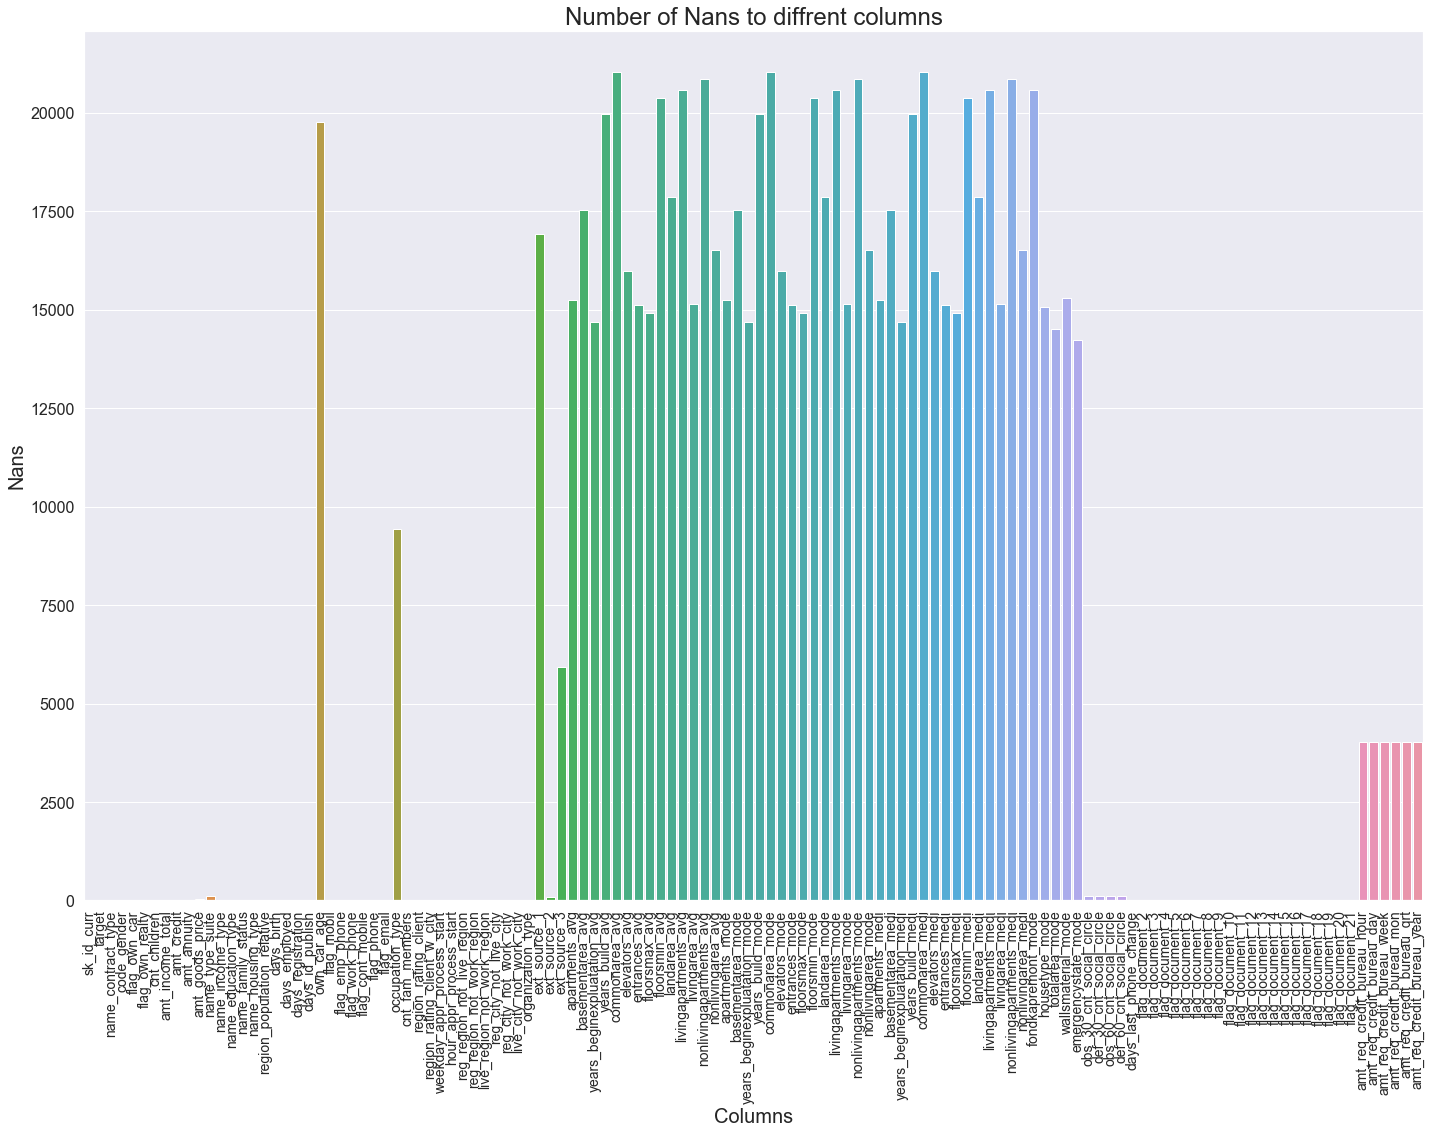

In [231]:
sns.set_style('darkgrid')
plt.figure(figsize = (24, 16))
sns.barplot(x = nan_columns_names, y = nan_columns_total)
plt.xticks(rotation = 90, fontsize = 14)
plt.yticks(fontsize = 16)
plt.xlabel('Columns', fontsize = 20)
plt.ylabel('Nans', fontsize = 20)
plt.title('Number of Nans to diffrent columns', fontsize = 24)
plt.show()

### *Центральные столбцы таблицы имеют больше процент пропущенных значений(конечные буквы столбцов: source_i, avg, mode, medi), помимо этого много пропусков в столбце own_car_age и последних 5 столбцах таблицы: AMT_REQ_CREDIT_BUREAU_... около 17% пропусков.*

In [232]:
credit['own_car_age'] = credit['own_car_age'].fillna(0)

### *В предположении о том, что пропуски в данном столбце обусловлены отсутствием у части кредитовавших машины. C остальными столбцами не понятно как заполнять пропуски, пока оставим их.*

In [233]:
credit.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

## Проверка на дубликаты

In [234]:
credit.duplicated().sum()

0

## Преобразование типов данных

In [235]:
float_into_int_columns = ['amt_income_total', 'amt_credit', 'amt_annuity', 'amt_goods_price', 'days_registration', 
                          'cnt_fam_members', 'own_car_age', 'obs_30_cnt_social_circle', 'def_30_cnt_social_circle', 
                          'obs_60_cnt_social_circle', 'def_60_cnt_social_circle', 'days_last_phone_change']
for column in float_into_int_columns:
    credit[column] = credit[column].astype('int', errors = 'ignore')

In [236]:
credit.head()

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,occupation_type,cnt_fam_members,region_rating_client,region_rating_client_w_city,weekday_appr_process_start,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,organization_type,ext_source_1,ext_source_2,ext_source_3,apartments_avg,basementarea_avg,years_beginexpluatation_avg,years_build_avg,commonarea_avg,elevators_avg,entrances_avg,floorsmax_avg,floorsmin_avg,landarea_avg,livingapartments_avg,livingarea_avg,nonlivingapartments_avg,nonlivingarea_avg,apartments_mode,basementarea_mode,years_beginexpluatation_mode,years_build_mode,commonarea_mode,elevators_mode,entrances_mode,floorsmax_mode,floorsmin_mode,landarea_mode,livingapartments_mode,livingarea_mode,nonlivingapartments_mode,nonlivingarea_mode,apartments_medi,basementarea_medi,years_beginexpluatation_medi,years_build_medi,commonarea_medi,elevators_medi,entrances_medi,floorsmax_medi,floorsmin_medi,landarea_medi,livingapartments_medi,livingarea_medi,nonlivingapartments_medi,nonlivingarea_medi,fondkapremont_mode,housetype_mode,totalarea_mode,wallsmaterial_mode,emergencystate_mode,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
0,100002,1,Cash loans,M,N,Y,0,202500,406597,24700,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648,-2120,0,1,1,0,1,1,0,Laborers,1,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000,1293502,35698,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186,-291,0,1,1,0,1,1,0,Core staff,2,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500,135000,6750,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260,-2531,26,1,1,1,1,1,0,Laborers,1,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

# Анализ основных признаков(чтобы изучить их поподробнее)

### TARGET - Целевая переменная (1 - клиент с трудностями оплаты: у него / нее была задержка платежа более чем на X дней ...

### NAME_CONTRACT_TYPE - Идентификация, если кредит наличными или возобновляемый

### CODE_GENDER - Пол клиента

### FLAG_OWN_CAR - Флаг, если клиент владеет автомобилем

### FLAG_OWN_REALTY - Флаг, если клиенту принадлежит дом или квартира

### CNT_CHILDREN - Количество детей у клиента

### AMT_INCOME_TOTAL - Доход клиента

### AMT_CREDIT - Сумма кредита по кредиту

### AMT_ANNUITY - Кредитный аннуитет

### AMT_GOODS_PRICE - Для потребительских кредитов это цена товаров, на которые предоставляется кредит.

### NAME_TYPE_SUITE - Кто сопровождал клиента, когда он подал заявку на кредит

### NAME_INCOME_TYPE - Тип дохода клиента (бизнесмен, работа, декретный отпуск)

### NAME_EDUCATION_TYPE - Уровень высшего образования, которого достиг клиент

### NAME_FAMILY_STATUS - Семейное положение клиента

### NAME_HOUSING_TYPE - Какова жилищная ситуация клиента (сдача в аренду, проживание с родителями, ...)

### REGION_POPULATION_RELATIVE - Нормализованное население региона, где живет клиент (большее число означает, что клиент живет в большем количестве ...

### DAYS_BIRTH - Возраст клиента в днях на момент подачи заявления

In [237]:
sns.set(style="white", palette="muted", color_codes=True)

In [238]:
main_features = ['target', 'name_contract_type', 'code_gender', 'flag_own_car', 'flag_own_realty', 'cnt_children', 
                 'amt_income_total', 'amt_credit', 'amt_annuity', 'amt_goods_price', 'name_type_suite', 'name_income_type',
                 'name_education_type', 'name_family_status', 'name_housing_type', 'region_population_relative', 'days_birth']

In [239]:
credit_main = credit[main_features]
credit_main.head()

,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,days_birth
0,1,Cash loans,M,N,Y,0,202500,406597,24700,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461
1,0,Cash loans,F,N,N,0,270000,1293502,35698,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765
2,0,Revolving loans,M,Y,Y,0,67500,135000,6750,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046
3,0,Cash loans,F,N,Y,0,135000,312682,29686,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005
4,0,Cash loans,M,N,Y,0,121500,513000,21865,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932


## Баланс возвратов/не возвратов

Text(0.5, 1.0, 'Распределение вернувших/невернувших кредит людей')

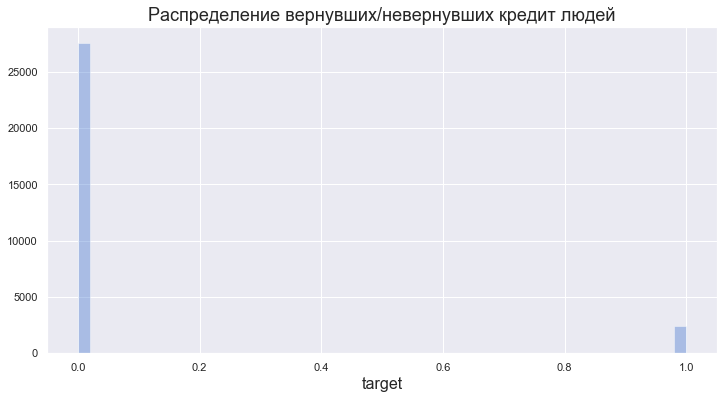

In [240]:
sns.set_style('darkgrid')
plt.figure(figsize = (12, 6))
sns.distplot(a = credit_main['target'], kde = False)
plt.xlabel('target', fontsize = 16)
plt.title('Распределение вернувших/невернувших кредит людей', fontsize = 18)

In [241]:
print('Доля не вернувших кредит людей: {}'.format(len(credit_main[credit_main['target'] == 1]) / len(credit_main)))

Доля не вернувших кредит людей: 0.0801


### *8% людей не возвращают кредит.*

## Доля не вернувших кредит среди мужчин/женщин

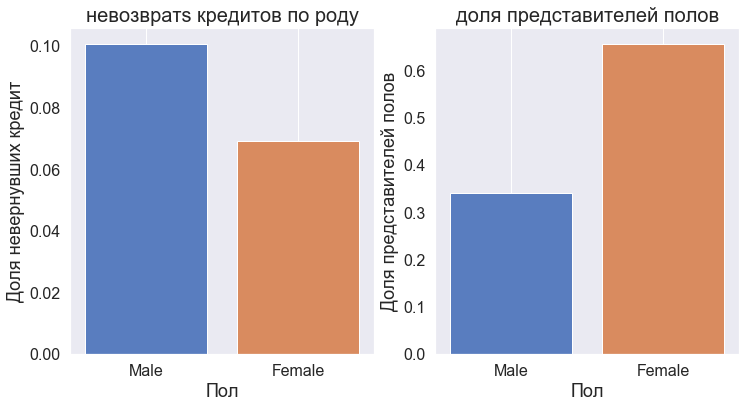

In [242]:
sns.set_style('darkgrid')
male_part_not_back = len(credit_main[(credit_main['code_gender'] == 'M') & (
    credit_main['target'] == 1)]) / len(credit_main[credit_main['code_gender'] == 'M'])
female_part_not_back = len(credit_main[(credit_main['code_gender'] == 'F') & (
    credit_main['target'] == 1)]) / len(credit_main[credit_main['code_gender'] == 'F'])
male_part = len(credit_main[credit_main['code_gender'] == 'M']) / len(credit_main['code_gender'])
female_part = len(credit_main[credit_main['code_gender'] == 'F']) / len(credit_main['code_gender'])

plt.figure(figsize = (12, 6))
plt.subplot(121)
ax1 = sns.barplot(x=['Male', 'Female'], y=[male_part_not_back, female_part_not_back])
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel('Пол', fontsize = 18)
plt.ylabel('Доля невернувших кредит', fontsize = 18)
plt.title('невозвратs кредитов по роду', fontsize = 20)
ax1.grid()

plt.subplot(122)
ax2 = sns.barplot(x = ['Male', 'Female'], y = [male_part, female_part])
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel('Пол', fontsize = 18)
plt.ylabel('Доля представителей полов', fontsize = 18)
plt.title('доля представителей полов', fontsize = 20)
ax2.grid()
plt.show()

### Доля невозвратов среди мужчин составляет около 10%, среди женщин -  около 7%, несмотря на то, что девушек, взявших кредит почти в двое больше мужчин.

## Зависимость возврата от возраста

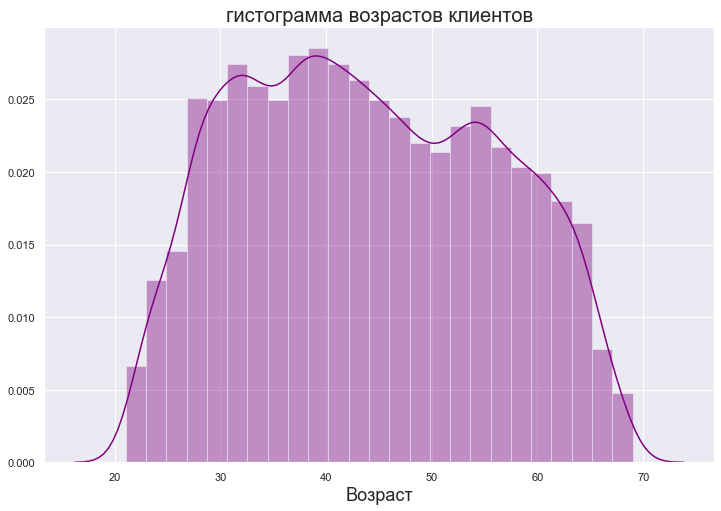

In [243]:
sns.set_style('darkgrid')
plt.figure(figsize = (12, 8))
sns.distplot(a = credit_main['days_birth'] / -365, bins = 25, color = 'purple')
plt.title('гистограмма возрастов клиентов', fontsize = 20)
plt.xlabel('Возраст', fontsize = 18)
plt.show()

### *Распределение напоминает нормальное и согласуется с реальной жизнью.*

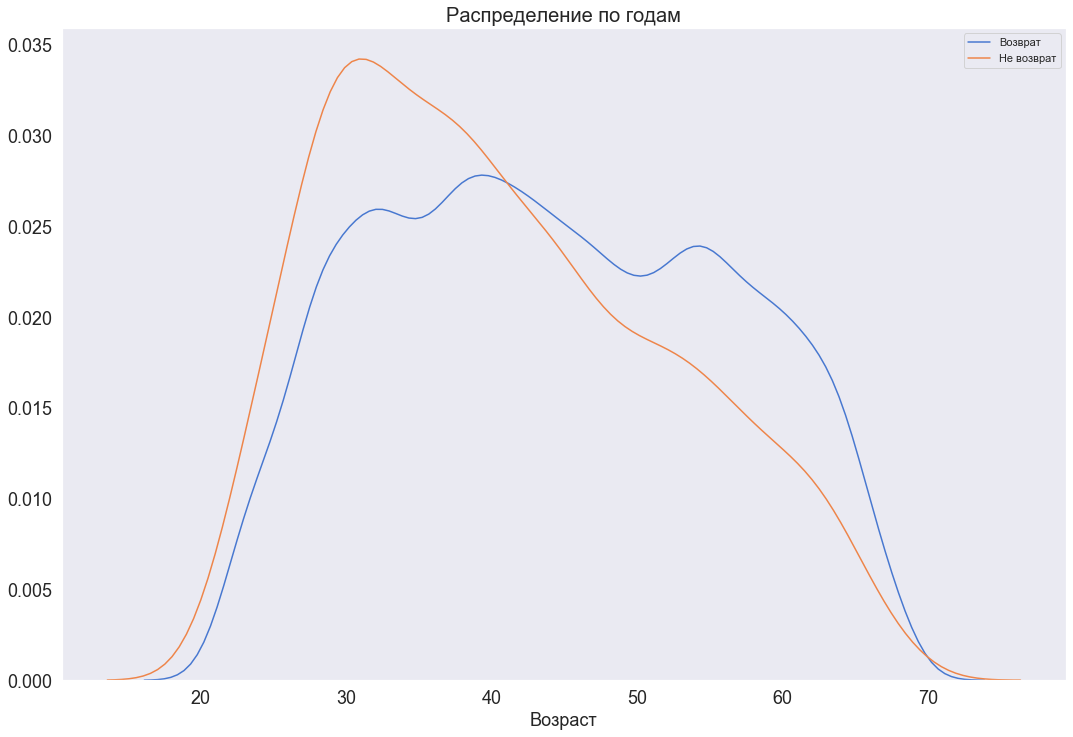

In [244]:
sns.set_style('darkgrid')
plt.figure(figsize = (18, 12))
ax = sns.kdeplot(credit_main.loc[credit_main['target'] == 0, 'days_birth'] / -365, label = 'Возврат')
ax = sns.kdeplot(credit_main.loc[credit_main['target'] == 1, 'days_birth'] / -365, label = 'Не возврат')
plt.xlabel('Возраст', fontsize = 18)
plt.title('Распределение по годам', fontsize = 20)
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 18)
ax.grid()
plt.show()

### *Молодые чаще не возвращают кредит, чем люди более старшего поколения.*

In [245]:
credit_main.head()

,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,days_birth
0,1,Cash loans,M,N,Y,0,202500,406597,24700,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461
1,0,Cash loans,F,N,N,0,270000,1293502,35698,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765
2,0,Revolving loans,M,Y,Y,0,67500,135000,6750,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046
3,0,Cash loans,F,N,Y,0,135000,312682,29686,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005
4,0,Cash loans,M,N,Y,0,121500,513000,21865,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932


## Функция построения диаграммы доли невернувших для разного типа значений столбца категориального признака

In [246]:
values_names = []
values_target_part = []
def diagram(column):
    sns.set_style('darkgrid')
    for value in credit_main[column].value_counts().index:
        values_names.append(value)
    for value_name in values_names:
        value_target_part = len(credit_main[(credit_main[column] == value_name) & (
    credit_main['target'] == 1)]) / len(credit_main[credit_main[column] == value_name])
        values_target_part.append(value_target_part)
    plt.figure(figsize = (12, 8))
    sns.barplot(x = values_names, y = values_target_part)
    plt.xlabel(column, fontsize = 20)
    plt.ylabel('Доля невернувших', fontsize = 20)
    if (len(values_names) >= 5):
        plt.xticks(fontsize = 18, rotation = 85)
    else:
        plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.title('Доля невернвших кредит для категори ' + column, fontsize = 24)
    plt.show()
    values_names.clear()
    values_target_part.clear()

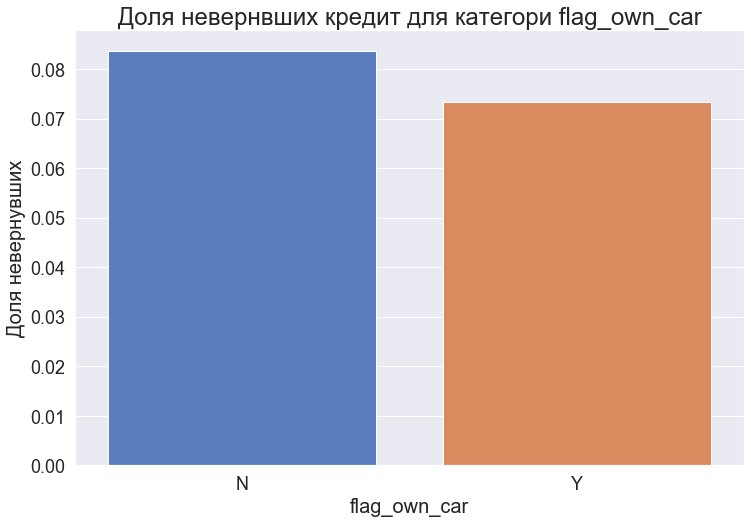

In [247]:
diagram('flag_own_car')

### *Люди не имеющие автомобиль чаще не возвращают кредит, чем те, что имеют. Возможно, это из-за того, что среди людей, имеющих автомобиль, есть те кто брали на него кредит и у них уже имеется опыт получения кредита. В среднем это суждение согласуется с жизнью.*

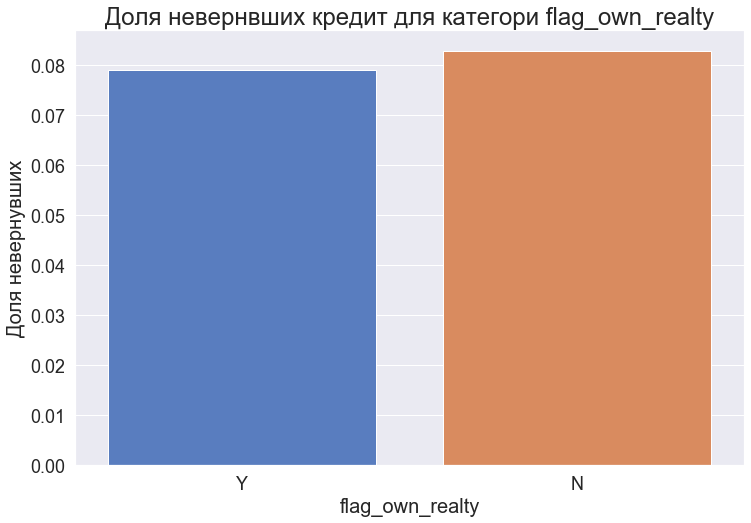

In [248]:
diagram('flag_own_realty')

### *Люди не имеющие собственной квартиры опять-таки чаще не возвращают кредит. Опять-таки, вероятно, это связано с тем, что люди, имеющие квартиру, брали ее в кредит и уже имеют опыт кредитования, нежели люди, не имеющие квартиры.*

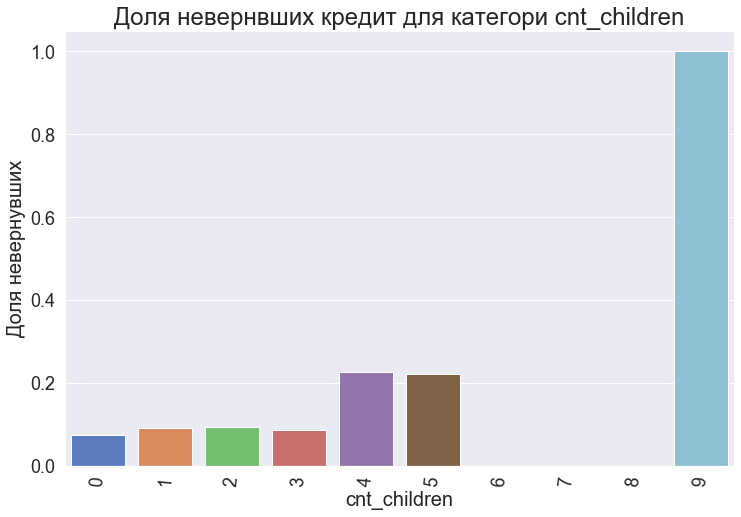

In [249]:
diagram('cnt_children')

In [250]:
print('Кол-во окредитованных, имеющих 9 детей: {}'.format(len(credit_main[credit_main['cnt_children'] == 9])))
print('Кол-во окредитованных, имеющих 4 детей: {}'.format(len(credit_main[credit_main['cnt_children'] == 4])))
print('Кол-во окредитованных, имеющих 5 детей: {}'.format(len(credit_main[credit_main['cnt_children'] == 5])))

Кол-во окредитованных, имеющих 9 детей: 1
Кол-во окредитованных, имеющих 4 детей: 44
Кол-во окредитованных, имеющих 5 детей: 9


### *Видно, что люди, имеющие 4 - 5 ребенка в семье значительно чаще не везвращают кредит. Но точность этого суждения довольно низка, т.к. всего таких объектов сравнительно немного с объектами всей выборки. Лучше не делать поспешных выводов.*

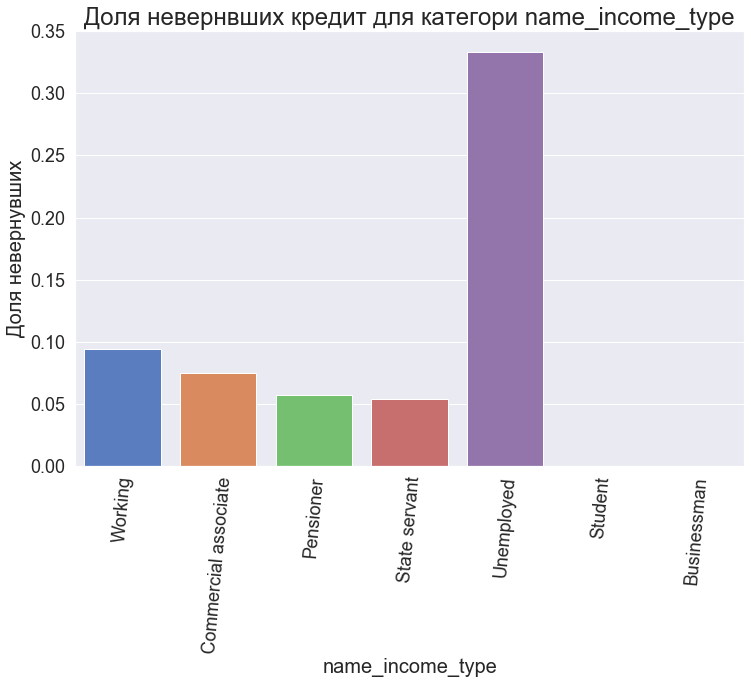

In [251]:
diagram('name_income_type')

In [252]:
print('Кол-во бизнесменов: {}'.format(len(credit_main[credit_main['name_income_type'] == 'Businessman'])))
print('Кол-во рабочих: {}'.format(len(credit_main[credit_main['name_income_type'] == 'Working'])))
print('Кол-во Студентов: {}'.format(len(credit_main[credit_main['name_income_type'] == 'Student'])))

Кол-во бизнесменов: 2
Кол-во рабочих: 15642
Кол-во Студентов: 2


### *Ярко выделенным недоверием пользуются не рабочие, доля не вернувших кредитов среди них составляет около 0.33, иначе говоря каждый третий нерабочий не возвращает кредит.*

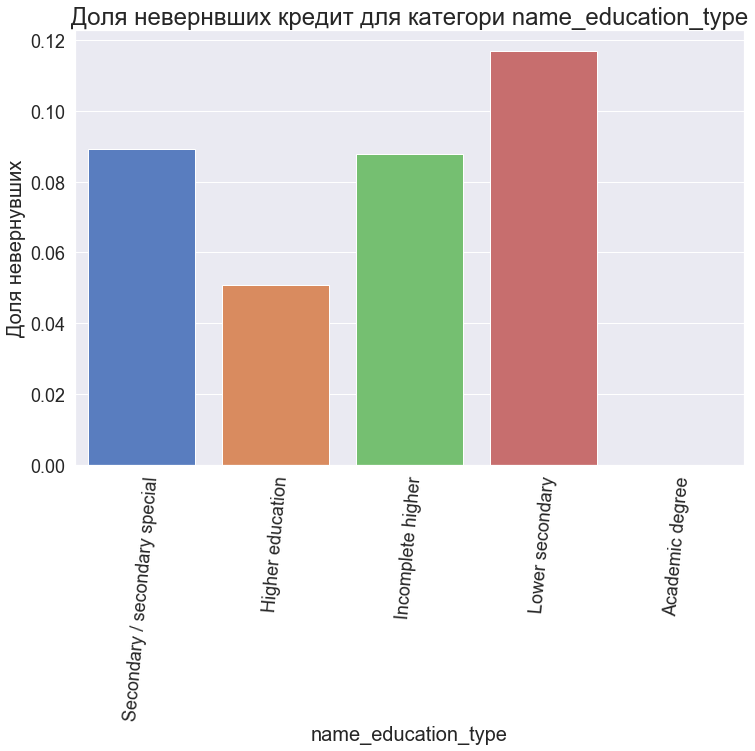

In [253]:
diagram('name_education_type')

In [254]:
print('Кол-во людей с академической степенью: {}'.format(
    len(credit_main[credit_main['name_education_type'] == 'Academic degree'])))

Кол-во людей с академической степени: 15


### *Люди с высшими образованием чаще других возвращают кредит, тогда как с 'Lower secondary'(что, по Российским меркам ближе к незаконченному среднему) - чаще всех не возвращают кредит.*

In [255]:
credit_main.head()

,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,days_birth
0,1,Cash loans,M,N,Y,0,202500,406597,24700,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461
1,0,Cash loans,F,N,N,0,270000,1293502,35698,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765
2,0,Revolving loans,M,Y,Y,0,67500,135000,6750,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046
3,0,Cash loans,F,N,Y,0,135000,312682,29686,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005
4,0,Cash loans,M,N,Y,0,121500,513000,21865,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932


## Взаимная корреляция признаков:

In [256]:
float_features = ['amt_income_total', 'amt_credit', 'amt_annuity', 'amt_goods_price', 'region_population_relative', 
                  'days_birth']

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]), <a list of 6 Text yticklabel objects>)

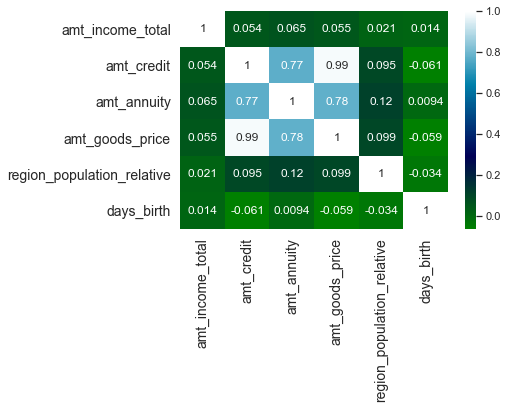

In [257]:
sns.heatmap(data = credit_main[float_features].corr(), cmap = 'ocean', annot = True)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

### *В целом все признаки не особо коррелируют друг перед другом за исключением столбцов amt_goods_price и amt_credit, amt_annuity и amt_credit, amt_annuity и amt_goods_price. Оставим один из признаков, который по моему усмотрению самый полезный(amt_annuity).*

In [258]:
credit_main = credit_main.drop(['amt_goods_price', 'amt_credit'], axis = 1)

In [259]:
credit = credit.drop(['amt_goods_price', 'amt_credit'], axis = 1)

In [260]:
credit.head()

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_annuity,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,occupation_type,cnt_fam_members,region_rating_client,region_rating_client_w_city,weekday_appr_process_start,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,organization_type,ext_source_1,ext_source_2,ext_source_3,apartments_avg,basementarea_avg,years_beginexpluatation_avg,years_build_avg,commonarea_avg,elevators_avg,entrances_avg,floorsmax_avg,floorsmin_avg,landarea_avg,livingapartments_avg,livingarea_avg,nonlivingapartments_avg,nonlivingarea_avg,apartments_mode,basementarea_mode,years_beginexpluatation_mode,years_build_mode,commonarea_mode,elevators_mode,entrances_mode,floorsmax_mode,floorsmin_mode,landarea_mode,livingapartments_mode,livingarea_mode,nonlivingapartments_mode,nonlivingarea_mode,apartments_medi,basementarea_medi,years_beginexpluatation_medi,years_build_medi,commonarea_medi,elevators_medi,entrances_medi,floorsmax_medi,floorsmin_medi,landarea_medi,livingapartments_medi,livingarea_medi,nonlivingapartments_medi,nonlivingarea_medi,fondkapremont_mode,housetype_mode,totalarea_mode,wallsmaterial_mode,emergencystate_mode,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
0,100002,1,Cash loans,M,N,Y,0,202500,24700,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648,-2120,0,1,1,0,1,1,0,Laborers,1,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000,35698,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186,-291,0,1,1,0,1,1,0,Core staff,2,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500,6750,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260,-2531,26,1,1,1,1,1,0,Laborers,1,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [261]:
credit.info(max_cols = 120)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 120 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   sk_id_curr                    30000 non-null  int64  
 1   target                        30000 non-null  int64  
 2   name_contract_type            30000 non-null  object 
 3   code_gender                   30000 non-null  object 
 4   flag_own_car                  30000 non-null  object 
 5   flag_own_realty               30000 non-null  object 
 6   cnt_children                  30000 non-null  int64  
 7   amt_income_total              30000 non-null  int32  
 8   amt_annuity                   30000 non-null  int32  
 9   name_type_suite               29875 non-null  object 
 10  name_income_type              30000 non-null  object 
 11  name_education_type           30000 non-null  object 
 12  name_family_status            30000 non-null  object 
 13  

## One - Hot преобразование категориальных признаков

In [262]:
credit = pd.get_dummies(credit)

## Заполнение пропусков медианой

In [263]:
for feature in credit.columns:
    if (credit[feature].isnull().sum() >= 15000):
        credit = credit.drop([feature], axis=1)

In [264]:
features_with_nan = []
for feature in credit.columns:
    if (credit[feature].isnull().sum() > 0):
        features_with_nan.append(feature)

In [265]:
features_with_nan

['ext_source_2',
 'ext_source_3',
 'years_beginexpluatation_avg',
 'floorsmax_avg',
 'years_beginexpluatation_mode',
 'floorsmax_mode',
 'years_beginexpluatation_medi',
 'floorsmax_medi',
 'totalarea_mode',
 'obs_30_cnt_social_circle',
 'def_30_cnt_social_circle',
 'obs_60_cnt_social_circle',
 'def_60_cnt_social_circle',
 'days_last_phone_change',
 'amt_req_credit_bureau_hour',
 'amt_req_credit_bureau_day',
 'amt_req_credit_bureau_week',
 'amt_req_credit_bureau_mon',
 'amt_req_credit_bureau_qrt',
 'amt_req_credit_bureau_year']

In [266]:
for feature in features_with_nan:
    if (credit[feature].dtype == 'float'):
        median = credit[credit[feature].isnull() == False][feature].median()
        credit[feature] = credit[feature].fillna(median)
    elif (credit[feature].dtype == 'int'):
        median = int(credit[credit[feature].isnull() == False][feature].median())
        credit[feature] = credit[feature].fillna(median)

In [267]:
credit.isnull().sum().sum()

0

# Признаки и метка

In [268]:
X = credit.drop(['target', 'sk_id_curr'], axis = 1)[0:27000]
Y = credit['target'][0:27000]
X_last_test = credit.drop(['target', 'sk_id_curr'], axis = 1)[27000:30000] # Выборка для просчета метрик в конце при построении модели(X)
Y_last_test = credit['target'][27000:30000] # Выборка для просчета метрик в конце при построении модели(Y)

# Разбиение на обучающую и тестовую выборки

In [269]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size = 0.8, test_size = 0.2, random_state = 1)

# Создание нормализованных данных для Логистической регрессии

In [270]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# модель - Логистическая регрессия

In [271]:
from sklearn.linear_model import LogisticRegressionCV

## Будем использовать стратифицированную, перемешивающуюся кросс - валидацию

In [272]:
from sklearn.model_selection import StratifiedShuffleSplit

In [273]:
cv_log = StratifiedShuffleSplit(n_splits = 3, test_size = 0.3, train_size = 0.7, random_state = 1)

In [274]:
Cs_list = [x * 2 for x in range(10) if x != 0]

## Параметры модели

In [275]:
log_regr = LogisticRegressionCV(Cs_list, cv = cv_log, scoring = 'accuracy', penalty = 'l2', n_jobs = -1)

In [276]:
%%time
log_regr.fit(X_train_scaled, y_train)

Wall time: 14.3 s


LogisticRegressionCV(Cs=[2, 4, 6, 8, 10, 12, 14, 16, 18], class_weight=None,
                     cv=StratifiedShuffleSplit(n_splits=3, random_state=1, test_size=0.3,
            train_size=0.7),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=100, multi_class='auto',
                     n_jobs=-1, penalty='l2', random_state=None, refit=True,
                     scoring='accuracy', solver='lbfgs', tol=0.0001, verbose=0)

In [277]:
log_regr.predict(X_test_scaled)[:500]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [278]:
np.array(credit['target'])[:500]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [279]:
log_regr.predict_proba(X_test_scaled)[:10]

array([[0.9357904 , 0.0642096 ],
       [0.97157643, 0.02842357],
       [0.95061753, 0.04938247],
       [0.86174563, 0.13825437],
       [0.97377774, 0.02622226],
       [0.96675821, 0.03324179],
       [0.95010677, 0.04989323],
       [0.9450653 , 0.0549347 ],
       [0.90615456, 0.09384544],
       [0.92623026, 0.07376974]])

### *Классификатор предсказал для всех объектов метку 0, что не является корректным, вероятнее всего эта проблема связана с тем, что объектов класса 1(не вернувших кредит) очень мало(8%). Попробуем решить эту проблему.*

# Oversampling 

In [280]:
from imblearn.over_sampling import SMOTE

In [281]:
sampler = SMOTE()

In [282]:
X_resampled, y_resampled = sampler.fit_resample(X, Y)

In [283]:
X_resampled = X_resampled.sample(frac = 1).reset_index(drop = True)
y_resampled = y_resampled.sample(frac = 1).reset_index(drop = True)

In [284]:
X_resampled_train, X_resampled_test, y_resampled_train, y_resampled_test = train_test_split(X_resampled, y_resampled,
                                                                                            train_size = 0.8, random_state = 1)

In [285]:
X_resampled_scaled_train = scaler.fit_transform(X_resampled_train)
X_resampled_scaled_test = scaler.fit_transform(X_resampled_test)

In [286]:
log_regr_res = LogisticRegressionCV(Cs = 20, cv = cv_log, scoring = 'accuracy', penalty = 'l2')

In [287]:
%%time
log_regr_res.fit(X_resampled_scaled_train, y_resampled_train)

Wall time: 30 s


LogisticRegressionCV(Cs=20, class_weight=None,
                     cv=StratifiedShuffleSplit(n_splits=3, random_state=1, test_size=0.3,
            train_size=0.7),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=100, multi_class='auto',
                     n_jobs=None, penalty='l2', random_state=None, refit=True,
                     scoring='accuracy', solver='lbfgs', tol=0.0001, verbose=0)

In [288]:
log_regr_predictions = log_regr_res.predict(X_resampled_scaled_test)

In [289]:
log_regr_probability_prediction = log_regr_res.predict_proba(X_resampled_scaled_test)

In [290]:
log_regr_predictions[:500]

array([0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0,

## accuracy

In [291]:
metrics.accuracy_score(log_regr_predictions, y_resampled_test)

0.4977862749044073

## confusion matrix

In [292]:
metrics.confusion_matrix(log_regr_predictions, y_resampled_test)

array([[2376, 2387],
       [2604, 2571]], dtype=int64)

## classification report

In [293]:
print(metrics.classification_report(y_resampled_test, log_regr_predictions))

              precision    recall  f1-score   support

           0       0.50      0.48      0.49      4980
           1       0.50      0.52      0.51      4958

    accuracy                           0.50      9938
   macro avg       0.50      0.50      0.50      9938
weighted avg       0.50      0.50      0.50      9938



## roc - auc

In [294]:
print(metrics.roc_auc_score(y_resampled_test, log_regr_predictions))

0.4978321515185389


### *Не далеко ушло от случайного классификатора. Проверим модель на отложенной выборке.*

# Проверка на отложенной выборке

In [295]:
log_regr_last_predictions = log_regr_res.predict(X_last_test)

## accuracy(last)

In [296]:
metrics.accuracy_score(Y_last_test, log_regr_last_predictions)

0.918

## confusion matrix(last)

In [297]:
metrics.confusion_matrix(Y_last_test, log_regr_last_predictions)

array([[2754,    0],
       [ 246,    0]], dtype=int64)

## classification report(last)

In [298]:
print(metrics.classification_report(Y_last_test, log_regr_last_predictions))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2754
           1       0.00      0.00      0.00       246

    accuracy                           0.92      3000
   macro avg       0.46      0.50      0.48      3000
weighted avg       0.84      0.92      0.88      3000



## roc - auc(last)

In [299]:
print(metrics.roc_auc_score(Y_last_test, log_regr_last_predictions))

0.5


### *Видно, что классификатор очень плохо работает с классом 1, несмотря на oversampling, возможно просто слабый классификатор, а возможно слишком сложные данные и много признаков.*

# модель - xgboost

In [300]:
from xgboost import XGBClassifier

In [301]:
xgb_model = XGBClassifier(max_depth = 15, learning_rate = 0.1, subsample = 0.8, random_state = 1)

## без oversampling:

In [302]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=1, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.8, tree_method=None,
              validate_parameters=False, verbosity=None)

In [303]:
xgb_predictions = xgb_model.predict(X_test)

In [304]:
xgb_predictions[:500]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## accuracy

In [305]:
metrics.accuracy_score(y_test, xgb_predictions)

0.917962962962963

## confusion matrix

In [306]:
metrics.confusion_matrix(y_test, xgb_predictions)

array([[4953,   10],
       [ 433,    4]], dtype=int64)

## classification report

In [307]:
print(metrics.classification_report(y_test, xgb_predictions))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      4963
           1       0.29      0.01      0.02       437

    accuracy                           0.92      5400
   macro avg       0.60      0.50      0.49      5400
weighted avg       0.87      0.92      0.88      5400



## roc_auc

In [308]:
print(metrics.roc_auc_score(y_test, xgb_predictions))

0.5035692038706566


### *Здесь уже лучше предсказания, однако по-прежнему для класса 1 маленькая f-мера из-за того, что маленький recall, то есть классификатор улавливает мало объектов класса 1. Попробуем упростить данные, убрав лишние данные, которые возможно каким-то образом путают классификатор.*

# Отбор признаков

In [309]:
credit.head()

,sk_id_curr,target,cnt_children,amt_income_total,amt_annuity,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,cnt_fam_members,region_rating_client,region_rating_client_w_city,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,ext_source_2,ext_source_3,years_beginexpluatation_avg,floorsmax_avg,years_beginexpluatation_mode,floorsmax_mode,years_beginexpluatation_medi,floorsmax_medi,totalarea_mode,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,name_contract_type_Cash loans,name_contract_type_Revolving loans,code_gender_F,code_gender_M,flag_own_car_N,flag_own_car_Y,flag_own_realty_N,flag_own_realty_Y,name_type_suite_Children,name_type_suite_Family,name_type_suite_Group of people,name_type_suite_Other_A,name_type_suite_Other_B,"name_type_suite_Spouse, partner",name_type_suite_Unaccompanied,name_income_type_Businessman,name_income_type_Commercial associate,name_income_type_Pensioner,name_income_type_State servant,name_income_type_Student,name_income_type_Unemployed,name_income_type_Working,name_education_type_Academic degree,name_education_type_Higher education,name_education_type_Incomplete higher,name_education_type_Lower secondary,name_education_type_Secondary / secondary special,name_family_status_Civil marriage,name_family_status_Married,name_family_status_Separated,name_family_status_Single / not married,name_family_status_Widow,name_housing_type_Co-op apartment,name_housing_type_House / apartment,name_housing_type_Municipal apartment,name_housing_type_Office apartment,name_housing_type_Rented apartment,name_housing_type_With parents,occupation_type_Accountants,occupation_type_Cleaning staff,occupation_type_Cooking staff,occupation_type_Core staff,occupation_type_Drivers,occupation_type_HR staff,occupation_type_High skill tech staff,occupation_type_IT staff,occupation_type_Laborers,occupation_type_Low-skill Laborers,occupation_type_Managers,occupation_type_Medicine staff,occupation_type_Private service staff,occupation_type_Realty agents,occupation_type_Sales staff,occupation_type_Secretaries,occupation_type_Security staff,occupation_type_Waiters/barmen staff,weekday_appr_process_start_FRIDAY,weekday_appr_process_start_MONDAY,weekday_appr_process_start_SATURDAY,weekday_appr_process_start_SUNDAY,weekday_appr_process_start_THURSDAY,weekday_appr_process_start_TUESDAY,weekday_appr_process_start_WEDNESDAY,organization_type_Advertising,organization_type_Agriculture,organization_type_Bank,organization_type_Business Entity Type 1,organization_type_Business Entity Type 2,organization_type_Business Entity Type 3,organization_type_Cleaning,organization_type_Construction,organization_type_Culture,organization_type_Electricity,organization_type_Emergency,organization_type_Government,organization_type_Hotel,organization_type_Housing,organization_type_Industry: type 1,organization_type_Industry: type 10,organization_type_Industry: type 11,organization_type_Industry: type 12,organization_type_Industry: type 13,organization_type_Industry: type 2,organization_type_Industry: type 3,organization_type_Industry: type 4,organization_type_Industry: type 5,organization_type_Industry: type 6,organization_type_Industry: type 7,organization_type_Ind

In [310]:
main_columns = ['sk_id_curr', 'target', 'cnt_children', 'amt_income_total', 'amt_annuity', 'region_population_relative',
                'days_birth', 'days_employed', 'days_registration', 'days_id_publish', 'own_car_age', 'flag_mobil',
                'flag_emp_phone', 'flag_work_phone', 'flag_cont_mobile', 'flag_phone', 'flag_email', 'cnt_fam_members',
                'region_rating_client', 'region_rating_client_w_city', 'hour_appr_process_start', 'reg_region_not_live_region',
                'reg_region_not_work_region', 'live_region_not_work_region', 'reg_city_not_live_city', 'reg_city_not_work_city',
                'live_city_not_work_city', 'ext_source_2', 'ext_source_3', 'years_beginexpluatation_avg', 'floorsmax_avg',
                'years_beginexpluatation_mode', 'floorsmax_mode', 'years_beginexpluatation_medi', 'floorsmax_medi',
                'totalarea_mode', 'amt_req_credit_bureau_year', 'name_contract_type_Cash loans', 
                'name_contract_type_Revolving loans', 'code_gender_F', 'code_gender_M', 'flag_own_car_N', 'flag_own_car_Y',
                'flag_own_realty_N', 'flag_own_realty_Y', 'name_income_type_Businessman',
                'name_income_type_Commercial associate', 'name_income_type_Pensioner', 'name_income_type_State servant',
                'name_income_type_Student', 'name_income_type_Unemployed', 'name_income_type_Working',
                'name_education_type_Academic degree', 'name_education_type_Higher education',
                'name_education_type_Incomplete higher', 'name_education_type_Lower secondary',
                'name_education_type_Secondary / secondary special', 'name_family_status_Civil marriage',
                'name_family_status_Married', 'name_family_status_Separated', 'name_family_status_Single / not married',
                'name_family_status_Widow']
# отбор признаков просто исходя из анализа признаков и здравого смылса

In [311]:
credit = credit[main_columns]

In [312]:
credit.head()

,sk_id_curr,target,cnt_children,amt_income_total,amt_annuity,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,cnt_fam_members,region_rating_client,region_rating_client_w_city,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,ext_source_2,ext_source_3,years_beginexpluatation_avg,floorsmax_avg,years_beginexpluatation_mode,floorsmax_mode,years_beginexpluatation_medi,floorsmax_medi,totalarea_mode,amt_req_credit_bureau_year,name_contract_type_Cash loans,name_contract_type_Revolving loans,code_gender_F,code_gender_M,flag_own_car_N,flag_own_car_Y,flag_own_realty_N,flag_own_realty_Y,name_income_type_Businessman,name_income_type_Commercial associate,name_income_type_Pensioner,name_income_type_State servant,name_income_type_Student,name_income_type_Unemployed,name_income_type_Working,name_education_type_Academic degree,name_education_type_Higher education,name_education_type_Incomplete higher,name_education_type_Lower secondary,name_education_type_Secondary / secondary special,name_family_status_Civil marriage,name_family_status_Married,name_family_status_Separated,name_family_status_Single / not married,name_family_status_Widow
0,100002,1,0,202500,24700,0.018801,-9461,-637,-3648,-2120,0,1,1,0,1,1,0,1,2,2,10,0,0,0,0,0,0,0.262949,0.139376,0.9722,0.0833,0.9722,0.0833,0.9722,0.0833,0.01490,1.0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0
1,100003,0,0,270000,35698,0.003541,-16765,-1188,-1186,-291,0,1,1,0,1,1,0,2,1,1,11,0,0,0,0,0,0,0.622246,0.535276,0.9851,0.2917,0.9851,0.2917,0.9851,0.2917,0.07140,0.0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0
2,100004,0,0,67500,6750,0.010032,-19046,-225,-4260,-2531,26,1,1,1,1,1,0,1,2,2,9,0,0,0,0,0,0,0.555912,0.729567,0.9816,0.1667,0.9816,0.1667,0.9816,0.1667,0.06855,0.0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0
3,100006,0,0,135000,29686,0.008019,-19005,-3039,-9833,-2437,0,1,1,0,1,0,0,2,2,2,17,0,0,0,0,0,0,0.650442,0.535276,0.9816,0.1667,0.9816,0.1667,0.9816,0.1667,0.06855,1.0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0
4,100007,0,0,121500,21865,0.028663,-19932,-3038,-4311,-3458,0,1,1,0,1,0,0,1,2,2,11,0,0,0,0,1,1,0.322738,0.535276,0.9816,0.1667,0.9816,0.1667,0.9816,0.1667,0.06855,0.0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0


# Построение последней модели по отобранным признакам

In [313]:
X = credit.drop(['sk_id_curr', 'target'], axis = 1)[0:27000]
Y = credit['target'][0:27000]
X_test_last = credit.drop(['sk_id_curr', 'target'], axis = 1)[27000:30000]
Y_test_last = credit['target'][27000:30000]

# over and under sampling

In [314]:
from imblearn.combine import SMOTEENN

In [315]:
under_over_sampling = SMOTEENN()

In [316]:
X_resampled, y_resampled = under_over_sampling.fit_resample(X, Y)

# train_test_split

In [317]:
X_resampled_train, X_resampled_test, Y_resampled_train, Y_resampled_test = train_test_split(X_resampled, y_resampled, 
                                                                                            train_size = 0.8, random_state = 2)

# xgboost fitting and prediction

In [318]:
xgb_model = XGBClassifier(max_depth = 15, learning_rate = 0.05, subsample = 0.8, random_state = 1) 

In [319]:
xgb_model.fit(X_resampled_train, Y_resampled_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.05, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=1, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.8, tree_method=None,
              validate_parameters=False, verbosity=None)

In [320]:
xgb_predictions = xgb_model.predict(X_resampled_test)

# Результат на тестовой сэмплированной выборке

In [321]:
print(metrics.classification_report(Y_resampled_test, xgb_predictions))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      3088
           1       0.98      0.93      0.96      4415

    accuracy                           0.95      7503
   macro avg       0.94      0.95      0.95      7503
weighted avg       0.95      0.95      0.95      7503



In [322]:
xgb_total_predictions = xgb_predictions = xgb_model.predict(X_test_last)

# Результат на отложенной выборке

In [323]:
print(metrics.classification_report(Y_test_last, xgb_total_predictions))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      2754
           1       0.24      0.11      0.15       246

    accuracy                           0.90      3000
   macro avg       0.58      0.54      0.55      3000
weighted avg       0.87      0.90      0.88      3000



### *Видно, что сложно предсказать точность и полноту для класса 1(не вернувших кредит) обычными моделями, тогда как для людей вернвших кредит показатели намного лучше. Если у банка стоит цель минимизировать риск(консервативная схема), то следует увеличивать precision(класс 1), это можно сделать например вводя в качестве метрики полную F меру(для класса 1) и акцент сделать на точности предсказания, или если банку нужно найти оптимальное между общим кол-вом клиентов(количеством) и риском, не возвращения кредита(качеством), имеет также  смысл работать с расширенной F - мерой, подбирая beta оптимально.*